In [13]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from twosigmafunc import R_score, split_data

In [3]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
train = pd.read_hdf('train.h5')

In [6]:
null_labels = [
    'technical_21',
    'technical_19',
    'technical_27',
    'technical_36',
    'technical_35',
    'technical_17',
    'technical_43',
    'technical_13',
    'fundamental_33',
    'technical_14',
    'technical_33',
    'fundamental_18',
    'fundamental_48',
    'fundamental_59',
    'technical_9',
    'technical_16',
    'technical_42',
    'technical_18',
    'fundamental_42',
    'fundamental_0',
    'fundamental_7',
    'fundamental_41',
    'technical_41',
    'fundamental_21',
    'fundamental_19',
    'technical_29',
    'technical_24',
    'derived_0',
    'derived_1',
    'fundamental_17',
    'technical_3',
    'fundamental_20',
    'fundamental_32',
    'fundamental_62',
    'fundamental_25',
    'technical_1',
    'fundamental_58',
    'derived_3',
    'technical_5',
    'fundamental_52',
    'technical_10',
    'technical_31',
    'technical_25',
    'technical_44',
    'technical_28',
    'fundamental_40',
    'fundamental_27',
    'fundamental_29',
    'fundamental_43',
    'fundamental_15',
    'fundamental_30',
    'fundamental_60',
    'fundamental_16',
    'fundamental_50',
    'fundamental_44',
    'fundamental_37',
    'fundamental_14',
    'fundamental_23',
    'fundamental_55',
    'fundamental_8',
    'fundamental_63',
    'fundamental_39',
    'fundamental_54',
    'derived_2',
    'derived_4',
    'fundamental_35',
    'fundamental_34',
    'fundamental_47',
    'fundamental_51',
    'fundamental_31',
    'fundamental_49',
    'fundamental_22',
    'fundamental_9',
    'fundamental_24',
    'fundamental_57',
    'fundamental_28',
    'fundamental_61',
    'fundamental_1',
    'fundamental_6',
    'fundamental_38',
    'fundamental_5']

etr_features = ['y_past',
                'tec20-30',
                'technical_30',
                'tec123',
                'technical_43',
                'technical_43_diff',
                'tec123_past',
                'technical_11_diff',
                'technical_2_diff',
                'technical_11',
                'technical_20',
                'technical_2',
                'fundamental_25_nan',
                'technical_14_diff',
                'technical_21_diff',
                'technical_9_nan',
                'technical_40',
                'technical_30_diff',
                'technical_6_diff',
                'technical_6',
                'technical_17_diff',
                'technical_17',
                'technical_14',
                'technical_7',
                'technical_19',
                'technical_44_nan',
                'fundamental_27_nan',
                'technical_18_nan',
                'technical_28_nan',
                'technical_21',
                'technical_42_nan',
                'technical_29_diff',
                'technical_20_diff',
                'technical_31_nan',
                'fundamental_53',
                'technical_24_nan',
                'technical_36',
                'technical_19_diff',
                'technical_27',
                'technical_29',
                'technical_35',
                'technical_22',
                'technical_41_nan',
                'fundamental_8',
                'fundamental_21',
                'fundamental_17_nan',
                'technical_34',
                'technical_16_nan',
                'technical_27_diff',
                'fundamental_33_nan',
                'fundamental_58',
                'derived_1_nan',
                'technical_10',
                'technical_25_nan',
                'fundamental_18',
                'fundamental_59',
                'technical_40_diff',
                'null_count',
                'fundamental_5_nan',
                'fundamental_48',
                'fundamental_47_nan',
                'technical_36_diff',
                'fundamental_41_nan',
                'fundamental_42_nan',
                'fundamental_0_nan',
                'fundamental_50',
                'fundamental_40',
                'technical_3_nan',
                'fundamental_23',
                'fundamental_49_nan',
                'fundamental_36',
                'technical_44',
                'fundamental_2',
                'fundamental_0',
                'technical_41',
                'fundamental_62_diff',
                'technical_38_diff',
                'fundamental_22_nan',
                'technical_12',
                'fundamental_62',
                'technical_37_diff',
                'fundamental_44',
                'technical_29_nan',
                'fundamental_24_nan',
                'technical_10_nan',
                'fundamental_46',
                'technical_1',
                'fundamental_54_nan',
                'fundamental_0_diff',
                'technical_12_diff',
                'technical_35_diff',
                'derived_3_nan',
                'fundamental_63_nan',
                'fundamental_31_nan',
                'fundamental_40_nan',
                'fundamental_35_nan',
                'technical_3',
                'fundamental_13']

In [7]:
seed = 17
excl = ['id', 'timestamp', 'y']
origin_features = [c for c in train.columns if c not in excl]
origin_features_exclude_y = [c for c in train.columns if c not in ['y']]
diff_features = [feature + '_diff' for feature in origin_features]
linear_features = ['technical_20_diff', 'tec20-30']
# End of Feature Selection #
d_mean = train.median(axis=0)

last_stamp = train.loc[train.timestamp == train.timestamp.max(), origin_features_exclude_y]

In [8]:
# add Nan tags #
def add_nan(data):
    Nan_counts = data.isnull().sum(axis=1)
    for feature in null_labels:
        data[feature + '_nan'] = pd.isnull(data[feature])
        d_mean[feature + '_nan'] = 0
    data['null_count'] = Nan_counts
# end of Nan tags #


def predict_y_past(x):
    w = np.array([-8.36489105, 9.19544792]).T
    return x.dot(w) - 0.00020021698404804056


In [9]:
def add_diff(data):
    data.sort_values(['id', 'timestamp'], inplace=True)
    data['id_diff'] = data.id.diff()
    for feature in origin_features:
        diff_tag = feature + '_diff'
        data[diff_tag] = data[feature].diff()
        d_mean[diff_tag] = 0
    data.loc[data.id_diff != 0, diff_features] = 0

In [11]:
ymean_dict = dict(train.groupby(["id"])["y"].median())

print('Processing data...')

train = train
add_diff(train)
add_nan(train)
train = train.fillna(d_mean)
train['tec20-30'] = train.technical_20 - train.technical_30
train['tec123'] = train['tec20-30'] + train.technical_13
train['tec123_past'] = train.tec123.shift()
train['y_past'] = train.y.shift()
train.loc[train.id_diff != 0, ['tec123_past', 'y_past']] = 0

Processing data...


In [14]:
low_y_cut = -0.075
high_y_cut = 0.075
X_train, y_train, X_test, y_test = split_data(train, etr_features)
y_above_cut = (y_train > high_y_cut)
y_below_cut = (y_train < low_y_cut)
y_within_cut = (~y_above_cut & ~y_below_cut)

In [15]:
# Generate models...
ridge_1 = Ridge()
ridge_2 = Ridge()
etr = ExtraTreesRegressor(n_estimators=128, max_depth=6, min_samples_leaf=30,
                          max_features=0.6, n_jobs=-1, random_state=seed, verbose=0)

print('Training Linear Model...\n', len(linear_features), 'features')
ridge_2.fit(X_train.loc[y_within_cut, linear_features], y_train.loc[y_within_cut])
ridge_1.fit(np.array(X_train.loc[y_within_cut, linear_features[0]]
                     ).reshape(-1, 1), y_train.loc[y_within_cut])

print('Training ETR Model...\n', len(etr_features), 'features')
etr.fit(X_train.loc[y_within_cut, etr_features], y_train.loc[y_within_cut])
# end of Generate models.
# full_df = pd.read_hdf('../input/train.h5')


# predicting...
print('Predicting...')


Training Linear Model...
 2 features
Training ETR Model...
 98 features
Predicting...


train etr without clip

In [16]:
etr1 = ExtraTreesRegressor(n_estimators=128, max_depth=6, min_samples_leaf=30,
                          max_features=0.6, n_jobs=-1, random_state=seed, verbose=0)
etr1.fit(X_train[etr_features], y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=6,
          max_features=0.6, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=30, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
          oob_score=False, random_state=17, verbose=0, warm_start=False)

In [17]:
R_score(etr.predict(X_test), y_test)

0.023467045826984025

In [18]:
R_score(etr1.predict(X_test), y_test)

0.029941824402437735

In [29]:
timestamp = 906
r_true = []
y_lr_1_p = 0
y_lr_2_p = 0
a = 0.5
b = 0.5
y_pred_acc = []
y_act_acc = []
reward = []
while timestamp <= 1812:
    test = test_data.loc[test_data.timestamp == timestamp]
    test = pd.concat([test, last_stamp])

    add_diff(test)
    test['tec20-30'] = test.technical_20 - test.technical_30
    test['tec123'] = test['tec20-30'] + test.technical_13
    test['tec123_past'] = test.tec123.shift()
    test.loc[test.id_diff != 0, 'tec123_past'] = 0
    test = test.loc[test.timestamp == timestamp]
    test.sort_index(inplace=True)
    add_nan(test)
    test.fillna(d_mean, inplace=True)

    test['y_past'] = predict_y_past(test[['tec123_past', 'tec123']])
    test.fillna(0, inplace=True)
    last_stamp = test.loc[test.timestamp == timestamp, origin_features_exclude_y]

    y_etr = etr.predict(test[etr_features])
    y_act = test_data.loc[test_data.timestamp == timestamp, 'y']
    y_lr_2 = ridge_2.predict(test[linear_features]).clip(low_y_cut, high_y_cut)
    y_lr_1 = ridge_1.predict(np.array(test[linear_features[0]]
                                      ).reshape(-1, 1)).clip(low_y_cut, high_y_cut)
    y = y_lr_1 * 0.05 + y_lr_2 * 0.2 + y_etr * 0.75
    r_1 = R_score(y_lr_1, y_act)
    r_2 = R_score(y_lr_2, y_act)
    r_etr = R_score(y_etr, y_act)
    R = R_score(y, y_act)
    y_pred_acc.extend(list(y))
    y_act_acc.extend(list(y_act))
    score = R_score(np.array(y_pred_acc), np.array(y_act_acc))
    reward.append(score)
    timestamp += 1
    if timestamp % 50 == 0:
        print('timestamp:', timestamp, '-->','current r2', R, 'overall r2', score)

KeyboardInterrupt: 

In [27]:
y_pred = ridge_2.predict(train[linear_features]).clip(low_y_cut, high_y_cut)
R_score(y_pred, train.y)

0.019685532997689853

final r2_score: 0.000635149355216


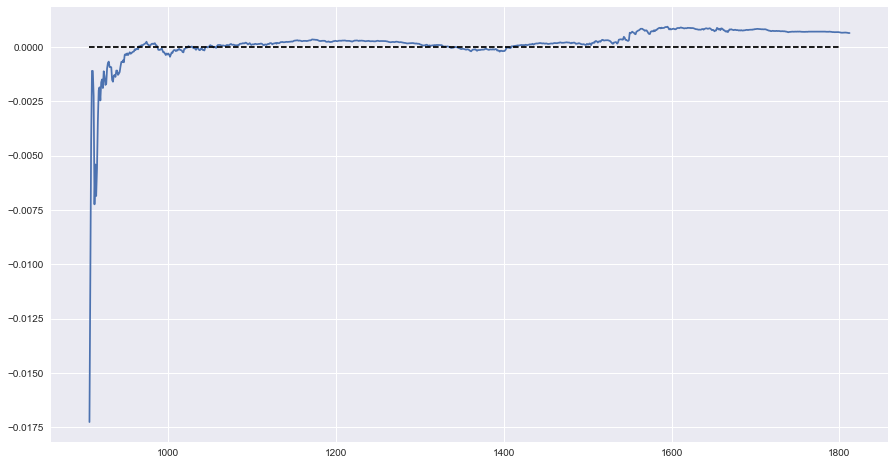

In [20]:
print('final r2_score:', reward[-1])
plt.figure(figsize=(15, 8))
plt.plot(range(906, test_data.timestamp.max() + 1), reward[-907:])
plt.plot([905, 1801], [0, 0], 'k--')
plt.show()